<a href="https://www.kaggle.com/code/jamijubaer/pepper-bell-disease-classification?scriptVersionId=101205070" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# **Pepper Bell Disease Classification**

Dataset used: https://www.kaggle.com/datasets/arjuntejaswi/plant-village

### **Loading the module and datas**

In [1]:
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt

In [2]:
#constants
IMAGE_SIZE=256
BATCH_SIZE = 32
CHANNELS =3
EPOCHS = 50
FILE_PATH="PlantVillage"

In [3]:
#copying only the necessary datasets . doing only Pepper bell
!mkdir "PlantVillage"
!cp -r "../input/plant-village/PlantVillage/Pepper__bell___Bacterial_spot/" "/kaggle/working/PlantVillage"
!cp -r "../input/plant-village/PlantVillage/Pepper__bell___healthy/" "/kaggle/working/PlantVillage"


In [4]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
            directory=FILE_PATH,
            shuffle=True,
            image_size=(IMAGE_SIZE,IMAGE_SIZE),
            batch_size = BATCH_SIZE,
)

Found 2475 files belonging to 2 classes.


2022-07-19 05:45:15.626916: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-19 05:45:15.883777: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-19 05:45:15.884938: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-19 05:45:15.897638: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [5]:
class_names = dataset.class_names
class_names

['Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy']

### **Data Visualization**

In [6]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

2022-07-19 05:45:19.104227: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


(32, 256, 256, 3)
[1 0 1 0 0 1 0 1 1 1 0 1 0 1 1 0 1 1 0 0 1 0 1 1 1 1 0 1 0 1 1 0]


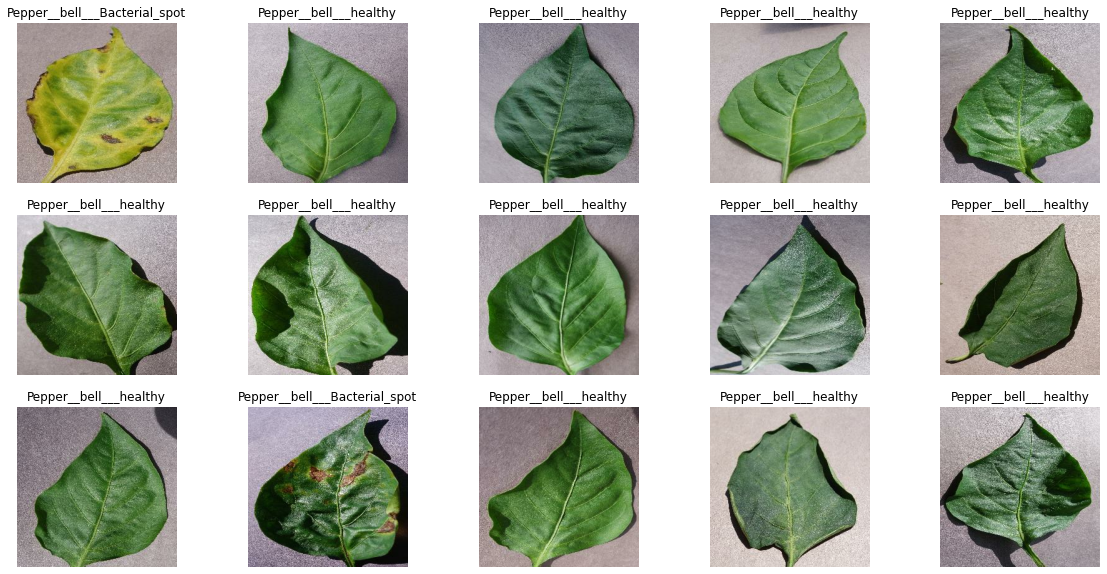

In [7]:
plt.figure(figsize=(20,10))
for image_batch, label_batch in dataset.take(1):
    for i in range(15):
        ax = plt.subplot(3,5,i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

### **Train Test Split**

In [8]:
def get_dataset_partitions(ds,train_split=0.8,test_split=0.1,valid_split=0.1,shuffle=True,shuffle_size=10000):
    assert  train_split+test_split+valid_split==1
    ds_size = len(ds)
    if shuffle:
        ds.shuffle(shuffle_size,seed=12)
    train_size = int(len(ds)*train_split)
    valid_size = int(len(ds)*valid_split)

  
    train_ds = ds.take(train_size)    
    valid_ds = ds.skip(train_size).take(valid_size)
    test_ds = ds.skip(train_size).skip(valid_size)
    
    return train_ds ,test_ds, valid_ds
    

In [9]:
train_ds ,test_ds, valid_ds = get_dataset_partitions(dataset)
    

In [10]:
print(len(train_ds))
print(len(test_ds))
print(len(valid_ds))

62
9
7


In [11]:
# performance improving by both using CPU and GPU
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
valid_ds = valid_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

### **Image Preprocessing**

In [12]:
rescale_and_resize=tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE) ,# will resize to the IMAGE_SIZE if there's any issue
    layers.experimental.preprocessing.Rescaling(1./255)  # Normalization
])

In [13]:
#data augmentation

data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

### **Building a Model**

In [14]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3


model = models.Sequential([
    rescale_and_resize,
    data_augmentation,
    
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [15]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (32, 256, 256, 3)         0         
_________________________________________________________________
sequential_1 (Sequential)    (32, 256, 256, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (32, 254, 254, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (32, 127, 127, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (32, 125, 125, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (32, 62, 62, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (32, 60, 60, 64)         

In [16]:
model.compile(
    optimizer="adam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=["accuracy"]
)

In [17]:
#model training
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=valid_ds,
    verbose=1,
    epochs=EPOCHS
    
)

Epoch 1/50


Cleanup called...
2022-07-19 05:45:27.763792: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


62/62 [==============================] - ETA: 0s - loss: 0.6838 - accuracy: 0.6038

Cleanup called...


62/62 [==============================] - 17s 78ms/step - loss: 0.6838 - accuracy: 0.6038 - val_loss: 0.4493 - val_accuracy: 0.7545
Epoch 2/50
62/62 [==============================] - 2s 36ms/step - loss: 0.3721 - accuracy: 0.8579 - val_loss: 0.1895 - val_accuracy: 0.9330
Epoch 3/50
62/62 [==============================] - 2s 37ms/step - loss: 0.2217 - accuracy: 0.9204 - val_loss: 0.2601 - val_accuracy: 0.9107
Epoch 4/50
62/62 [==============================] - 2s 36ms/step - loss: 0.1478 - accuracy: 0.9582 - val_loss: 0.0504 - val_accuracy: 0.9866
Epoch 5/50
62/62 [==============================] - 2s 36ms/step - loss: 0.0832 - accuracy: 0.9773 - val_loss: 0.0095 - val_accuracy: 1.0000
Epoch 6/50
62/62 [==============================] - 2s 36ms/step - loss: 0.0601 - accuracy: 0.9839 - val_loss: 0.0307 - val_accuracy: 1.0000
Epoch 7/50
62/62 [==============================] - 2s 36ms/step - loss: 0.0295 - accuracy: 0.9945 - val_loss: 0.0073 - val_accuracy: 1.0000
Epoch 8/50
62/62 [=====

In [18]:
scores = model.evaluate(test_ds)
scores

Cleanup called...


9/9 [==============================] - 3s 25ms/step - loss: 0.0159 - accuracy: 0.9963


[0.015859069302678108, 0.9962546825408936]

### **Plotting Model Accuracy**

In [19]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

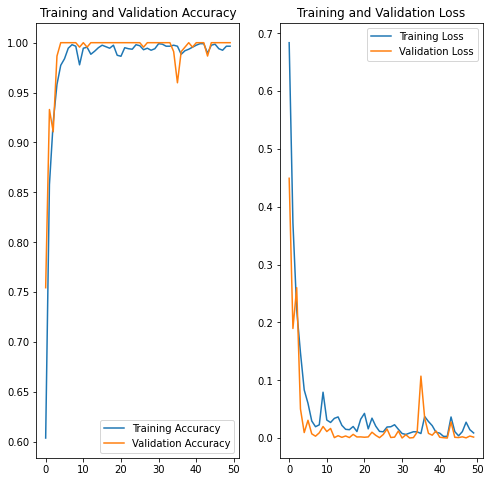

In [20]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### **Running prediction on a sample image**

first image to predict
actual label: Pepper__bell___healthy
predicted label: Pepper__bell___healthy


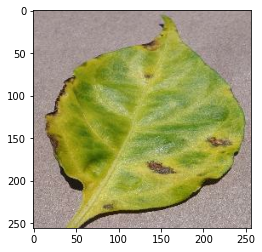

In [21]:
for images_batch, labels_batch in test_ds.take(1):
    first_image = image_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
   
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])
    break

### **Predictions**

In [22]:
def predict_pepper_bell_diseases(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)
  

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

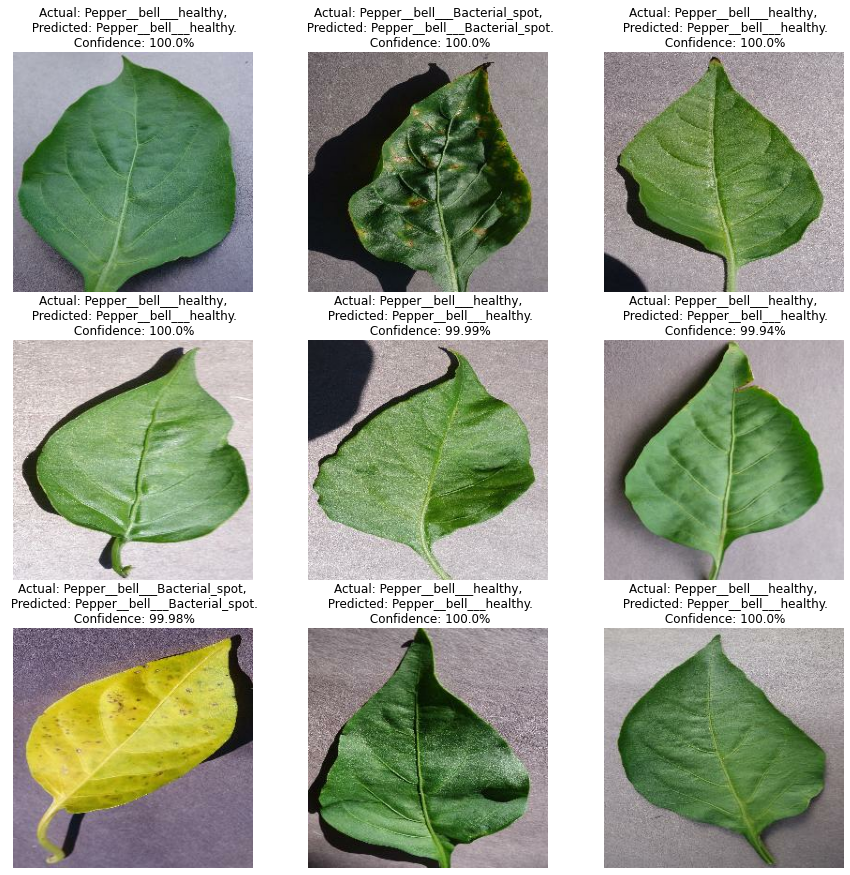

In [23]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict_pepper_bell_diseases(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

### **Saving the Model**

In [24]:
!mkdir models
import os
model_version=max([int(i) for i in os.listdir("models") + [0]])+1
model.save(f"models/bell_pepper_{model_version}")

2022-07-19 05:47:47.637107: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


In [25]:
model.save("bell_pepper.h5")

In [26]:
os.chdir(r'/kaggle/working')

from IPython.display import FileLink
FileLink(r'bell_pepper.h5')

/kaggle/working/bell_pepper.h5

#### **THE END :)**